In [1]:
import os
import numpy as np
import igraph as ig
import matplotlib.pyplot as plt
import pandas as pd
import random
from src.utils import plot_graph, prepare_graph, analyze_graph, prepare_graph_for_betweenness, prepare_graph_for_degree
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde
import seaborn as sns

## Make two networks

- A and B each post a tweet within **s** seconds of each other.
- Both tweets contain the same entity **R**.

A tie is established between **A** and **B** if at least **r** co-actions occur between them. You are to generate two networks based on varying parameters:

1. **Bot Identification Network**: DONE

2. **Ideological/Topical Group Network**:
   - Parameters: Larger **s** and **R = URLs** or **lang**?.
   - Reasoning: Accounts posting the same URL within a larger time window, even without precise synchronization, may indicate ideological or topical connections.


In [6]:
df = pd.read_csv("../../../data/df_ideology_connections_s60.csv")
df[["author1", "author2"]] = df[["author1", "author2"]].astype(str)
authors = set(df["author1"])
authors.update(df["author2"])
print(f"Distinct authors: {len(authors)}")
df.info()

Distinct authors: 11095
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554897 entries, 0 to 554896
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    554897 non-null  int64  
 1   id1           554897 non-null  int64  
 2   id2           554897 non-null  int64  
 3   url           554897 non-null  object 
 4   text1         554897 non-null  object 
 5   text2         554897 non-null  object 
 6   lang1         554897 non-null  object 
 7   lang2         554897 non-null  object 
 8   author1       554897 non-null  object 
 9   author2       554897 non-null  object 
 10  time1         554897 non-null  object 
 11  time2         554897 non-null  object 
 12  seconds_diff  554897 non-null  float64
dtypes: float64(1), int64(3), object(9)
memory usage: 55.0+ MB


In [57]:
R_MIN = 2
df_counts = df.groupby(["author1", "author2", "lang1", "url"]).size().reset_index(name="r_count")
df_counts = df_counts[df_counts["r_count"] >= R_MIN]
print(df_counts.describe())
df_counts.info()

           r_count
count  2103.000000
mean    183.819781
std     424.402981
min       2.000000
25%       2.000000
50%       5.000000
75%     119.500000
max    2396.000000
<class 'pandas.core.frame.DataFrame'>
Index: 2103 entries, 76 to 170359
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   author1  2103 non-null   object
 1   author2  2103 non-null   object
 2   lang1    2103 non-null   object
 3   url      2103 non-null   object
 4   r_count  2103 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 98.6+ KB


Order: 892
Size: 1080
No .of Components: 212
Size of largest component: 115
Density: 0.0027177605652941974
Transitivity: 0.6188788173518163


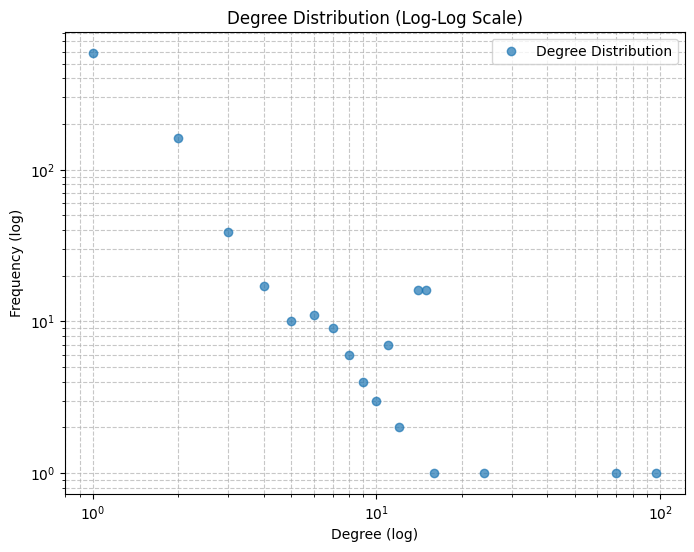

In [58]:
gideo = ig.Graph(len(authors))
gideo["title"] = "Bot Graph"
gideo.vs["name"] = list(authors)
gideo.vs["text1"] = df["text1"]
gideo.vs["text2"] = df["text2"]
gideo.vs["url"] = df["url"]
gideo.add_edges(df_counts[["author1", "author2"]].apply(tuple, axis=1).tolist())
gideo.delete_vertices([v.index for v in gideo.vs if v.degree() < 1])
gideo, _ = prepare_graph(gideo)
analyze_graph(gideo)

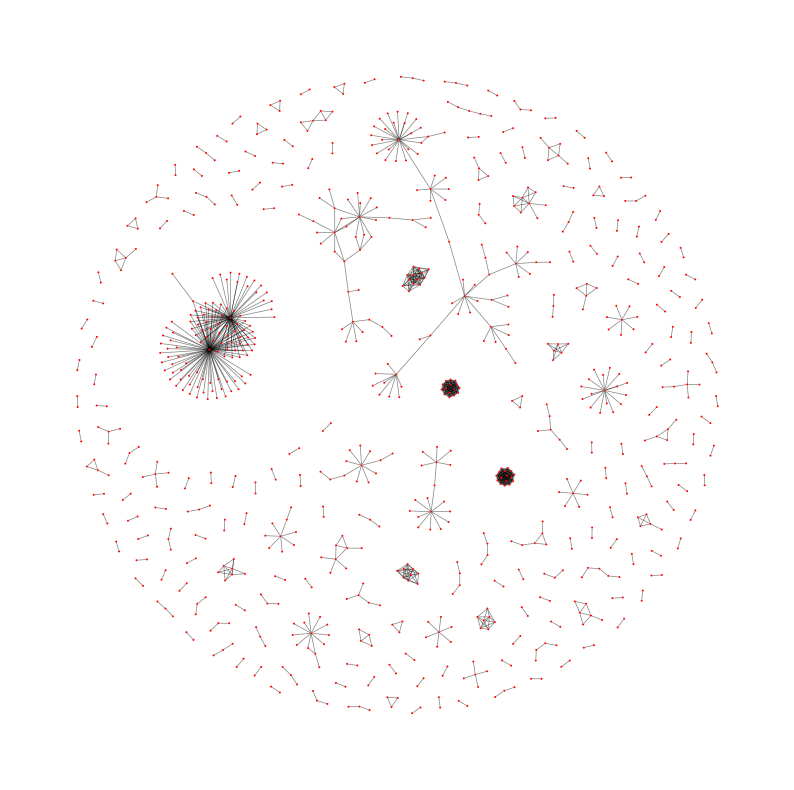

In [59]:
gideo.vs["size"] = 2
gideo.es["width"] = .5
gideo.es["color"] = "rgba(1, 1, 1, .5)"
plot_graph(gideo, gideo.layout_auto())

In [60]:
for component in gideo.components():
    if len(component) > 100:
        print(f"Component len={len(component)}")
        for field in gideo.vs[component]["text1"]:
            print(f"Field: {field}")

Component len=115
Field: BBCBreaking : Live reaction as a two-week UN summit in Paris agrees a climate deal: https://t.co/KHAelJvoW7 #COP21… https://t.co/Cgwepi3Xtb
Field: Hurrah - deal is made #COP21 - take your step in support #seethelightuk - https://t.co/hIuIzeJpHQ
Field: Happy for this global step. Historic time #ParisAgreement:  https://t.co/O5xJBnY3fY #cop21"
Field: #COP21 climate change summit reaches deal in Paris https://t.co/oyv2fLycn2
Field: #COP21 Comité de revisión lingüística y técnica da a conocer sus recomendaciones sobre el texto #EnVivo https://t.co/5dizngasVY
Field: Here we go! #COP21 #FinalAgreement https://t.co/HJDTpCJJMv
Field: Here is the Draft Paris Agreement. Final #COP21 session is about to begin: https://t.co/crsIXGeJJg @SBSNews https://t.co/sd2xVYLEXZ
Field: What looks to be the final plenary session of #COP21 is about ready to start now at https://t.co/ePVLkvAOw9. Click to watch history be made.
Field: #COP21 je félicite le président Hollande pour l'organi

communities: 3


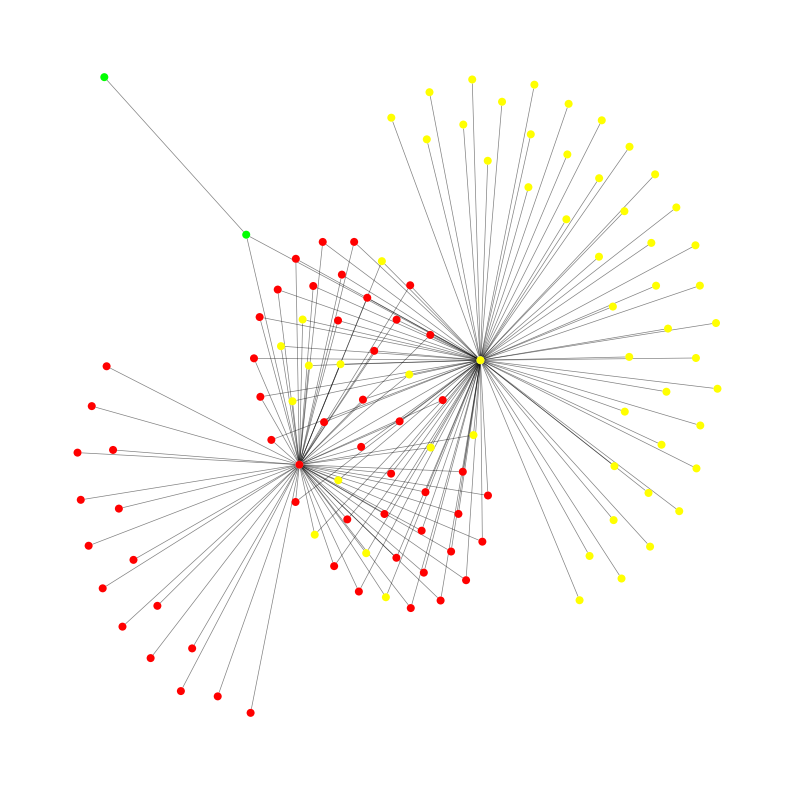

In [61]:
giant = gideo.components().giant()
communities = giant.community_multilevel()
print(f"communities: {len(communities)}")
rainbow_colors = [
    "#FF0000",  # Red
    "#FFFF00",  # Yellow
    "#00FF00",  # Green
    "#0000FF",  # Blue
    "#8B00FF",  # Violet
    "#FF6347",  # Tomato
    "#40E0D0",  # Turquoise
    "#FFD700",  # Gold
    "#9ACD32",  # Yellow Green
    "#FF4500",  # Orange Red
    "#2E8B57",  # Sea Green
    "#9932CC",  # Dark Orchid
    "#FF1493",  # Deep Pink
    "#00FA9A",  # Medium Spring Green
    "#D2691E",  # Chocolate
    "#ADFF2F",  # Green Yellow
    "#8A2BE2",  # Blue Violet
    "#DC143C"   # Crimson
]
colors = [rainbow_colors[i] for i in ((communities.membership))]
plt.figure(figsize=(10,10))
# analyze_graph(giant)
ig.plot(giant,
        layout=giant.layout("fr"),
        vertex_color=colors,
        vertex_size=8,
        vertex_label=None,
        backend="matplotlib")

In [62]:
feature = "text1"
for i, community in enumerate(communities):
    print(f"Community {i}:")
    for vertex_id in community:
        vertex = giant.vs[vertex_id]
        
        feature_value = vertex[feature]
        print(f"  -  Vertex:{vertex_id}: {feature_value}")
    print("-" * 60)

Community 0:
  -  Vertex:0: BBCBreaking : Live reaction as a two-week UN summit in Paris agrees a climate deal: https://t.co/KHAelJvoW7 #COP21… https://t.co/Cgwepi3Xtb
  -  Vertex:1: Hurrah - deal is made #COP21 - take your step in support #seethelightuk - https://t.co/hIuIzeJpHQ
  -  Vertex:3: #COP21 climate change summit reaches deal in Paris https://t.co/oyv2fLycn2
  -  Vertex:4: #COP21 Comité de revisión lingüística y técnica da a conocer sus recomendaciones sobre el texto #EnVivo https://t.co/5dizngasVY
  -  Vertex:7: What looks to be the final plenary session of #COP21 is about ready to start now at https://t.co/ePVLkvAOw9. Click to watch history be made.
  -  Vertex:15: #COP21 je félicite le président Hollande pour l'organisation(Sassou) #sassoui #NRCG @Thierry_mounga https://t.co/yVEpRiedIy 25
  -  Vertex:16: #COP21 je félicite le président Hollande pour l'organisation(Sassou) #sassoui #NRCG @Thierry_mounga https://t.co/yVEpRiedIy 25
  -  Vertex:17: #COP21 je félicite le présid